<a href="https://colab.research.google.com/github/TaisiaKozharina/WSI_artifact_segmentation/blob/main/yolo_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prep

In [ ]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
import torch
import os
import numpy as np
import torchvision.transforms as transforms
import cv2
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from tifffile import imread, imwrite
from PIL import Image
from pathlib import Path
from skimage import measure
from skimage import color
from glob import glob
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # force_remount=True

Mounted at /content/drive


# 2. Helpers

In [ ]:
def extract_segmets(annotation, original):

  segments = []

  for channel in annotation:
    labeled = torch.Tensor(measure.label(channel, connectivity=2))
    labels = torch.unique(labeled)

    for label in labels[labels != 0]:
      mask = torch.where(labeled == label, 1, 0).repeat(3,1,1)
      masked_original = original * mask
      segments.append(torch.Tensor(masked_original))


  return segments

In [ ]:
class WSI(Dataset):
    """
    Whole-Slide Image dataset

    Arguments:
          annotations_path (string): Path to the root folder on GDrive of annotations.
          images_path (string): Path to the root folder on GDrive of original WSI images.
          transform (callable, optional): Optional transform to be applied on a sample.
          demo_mode (Boolean): images are processed at lower quality for speed purposes and storage economy
          cached (Boolean): if enabled, data is cached for faster access (no recalculations if calculated previously, mosntly for segments)


      __getitem___(self, index):
        Returns sample elements by index. Index is taken in respect to unordered dataset stored on google drive.
        * id: string, ID of sample
        * original: torch.tensor, RBG combination of 3 channels,
        * annotation: torch.tensor, Grayscale annotation map,
        * segments: list of RBG separated annotated segments

    """

    def __init__(self, annotations_path, images_path):
      self.annotations_path = annotations_path
      self.images_path = images_path

    def __len__(self):
      return len(glob(self.annotations_path))

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def __getitem__(self, index):
      # /content/drive/MyDrive/pathdata/wsi_dataset/images/test/BOMI2_TIL_1_Core[1,11,J]_[22093,52204]_component_data.png
      # /content/drive/MyDrive/pathdata/bin_maps/BOMI2_TIL_1_Core[1,1,A]_[5091,35249]_binary_map.tif
      original_path = sorted(glob(self.images_path))[index]
      ID = Path(original_path).name.replace("_component_data.png","")
      annotation_path = f"{self.annotations_path}/{ID}_binary_map.tif"

      if original_path in glob(self.images_path):
        original = read_image(original_path)
        annotation = torch.Tensor(imread(annotation_path).astype(np.float32))
        segments = extract_segmets(annotation, original)

      else:
        print(f"Corresponding original image file not found for sample: {ID}")
        original = torch.Tensor([])
        annotation = torch.Tensor([])
        segments = []

      sample = {
          'id': ID,
          'original': original,
          'annotation': annotation,
          'segments': segments
      }

      return sample


In [ ]:
def recursive_file_search(root_folder, substring, extension):
  found_files = []
  for root, dirs, files in os.walk(root_folder):
      for file in files:
          if file.endswith(extension) and substring in file:
              found_files.append(os.path.join(root, file))
  return found_files


def read_img_cv2(tensor):

  image = np.float32(tensor.permute(1, 2, 0).numpy())
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  (thresh, binary_img) = cv2.threshold(grayscale_image, 0.01, 2, 0)

  binary_img = binary_img.astype(np.uint8)

  contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #error here

  image_for_plot = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

  return np.array(contours, dtype=object), image_for_plot

In [ ]:
clusters_path = '/content/drive/MyDrive/pathdata/clusters'
segment_path = '/content/drive/MyDrive/pathdata/segments_with_padding'

image_width = 3752
image_height = 2808


def sample_to_yolo_format(sample, out_dir):

  # Find all segments of sample
  segment_paths = recursive_file_search(clusters_path, sample['id'], '.png')

  txt_filepath = os.path.join(out_dir, f"{sample['id']}_component_data.txt")
  segments = sample['segments']

  # Start writing to label txt file
  with open(txt_filepath, 'a+') as f:

    # Extract class and border coordinates
    for path in tqdm(segment_paths, leave=False):

      seg_index = int(str.split(path,"_seg_")[1].replace(".png",""))
      contours, img = read_img_cv2(segments[seg_index])
      cluster_id = str.split(path.replace(f"{clusters_path}/cluster_", ""), "/")[0]

      if cluster_id!="" and cluster_id != "3" and cluster_id != "6":
        formatted_contours = np.concatenate([coord for contour in contours for coord in contour]).flatten()
        normalized_contours = [round(coord / image_width , 3) if i % 2 == 0 else round(coord / image_height, 3) for i, coord in enumerate(formatted_contours)]

        cluster_new = cluster_id
        if cluster_id == "4":
          cluster_new = "3"
        elif cluster_id == "5":
          cluster_new = "4"
        elif cluster_id == "7":
          cluster_new = "5"
        elif cluster_id == "8":
          cluster_new = "6"

        print(" ".join(map(str, [cluster_new] + normalized_contours)))
        f.write(" ".join(map(str, [cluster_new] + normalized_contours)) + '\n')
      else:
        print("Not assigned to cluster or ignored")

In [ ]:
# PATHS
bin_map_dir = '/content/drive/MyDrive/pathdata/bin_maps'
originals_dir_train = '/content/drive/MyDrive/pathdata/wsi_dataset/images/train/*.png'
originals_dir_test = '/content/drive/MyDrive/pathdata/wsi_dataset/images/test/*.png'
originals_dir_val = '/content/drive/MyDrive/pathdata/wsi_dataset/images/val/*.png'

labels_path_train = "/content/drive/MyDrive/pathdata/wsi_dataset/labels/train"
labels_path_test = "/content/drive/MyDrive/pathdata/wsi_dataset/labels/test"
labels_path_val = "/content/drive/MyDrive/pathdata/wsi_dataset/labels/val"

samples = WSI(bin_map_dir, originals_dir_val)
for i in range(len(glob(originals_dir_val))):
  sample = samples[i]
  sample_to_yolo_format(sample, labels_path_val)



  0%|          | 0/15 [00:00<?, ?it/s]

Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
6 0.352 0.033 0.351 0.034 0.351 0.035 0.352 0.035 0.352 0.036 0.352 0.036 0.352 0.037 0.353 0.038 0.353 0.038 0.354 0.037 0.354 0.036 0.353 0.036 0.353 0.035 0.353 0.034 0.353 0.034 0.353 0.033
6 0.653 0.062 0.652 0.062 0.652 0.062 0.651 0.063 0.651 0.064 0.651 0.064 0.651 0.064 0.651 0.065 0.65 0.065 0.649 0.066 0.649 0.067 0.649 0.067 0.649 0.069 0.649 0.069 0.649 0.07 0.651 0.072 0.651 0.072 0.651 0.072 0.653 0.072 0.654 0.072 0.654 0.072 0.654 0.072 0.654 0.072 0.655 0.071 0.655 0.071 0.655 0.071 0.655 0.071 0.655 0.071 0.656 0.071 0.657 0.071 0.657 0.071 0.658 0.071 0.

  0%|          | 0/14 [00:00<?, ?it/s]

Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
6 0.786 0.362 0.785 0.363 0.785 0.363 0.785 0.363 0.784 0.363 0.784 0.363 0.784 0.363 0.784 0.364 0.783 0.364 0.783 0.364 0.783 0.364 0.783 0.364 0.783 0.365 0.782 0.365 0.782 0.368 0.782 0.369 0.782 0.369 0.781 0.369 0.782 0.37 0.782 0.371 0.784 0.371 0.784 0.37 0.785 0.37 0.785 0.37 0.785 0.37 0.785 0.37 0.786 0.37 0.787 0.371 0.787 0.372 0.787 0.372 0.787 0.373 0.788 0.373 0.788 0.373 0.788 0.374 0.789 0.374 0.789 0.375 0.789 0.376 0.791 0.376 0.791 0.376 0.791 0.375 0.792 0.374 0.792 0.374 0.793 0.373 0.793 0.373 0.793 0.373 0.794 0.372 0.794 0.37 0.793 0.369 0.793 0.369 0.793 0.368 0.793 0.368 0.792 0.367 0.791 0.367 0.791 0.366 0.791 0.366 0.79 0.366 0.79 0.366 0.789 0.365 0.789 0.365 0.789 0.365 0.788 0.365 0.788 0.364 0.788 0.364 0.787 0.363 0.786 0.363 0.786 0.362
6 0.231 0.88 0.231 0.88 0.23 0.88 0.23 0.

  0%|          | 0/29 [00:00<?, ?it/s]

4 0.674 0.752 0.674 0.753 0.674 0.753 0.673 0.753 0.673 0.753 0.673 0.754 0.672 0.754 0.672 0.754 0.671 0.754 0.671 0.755 0.67 0.755 0.67 0.756 0.67 0.756 0.669 0.757 0.669 0.757 0.668 0.757 0.668 0.757 0.668 0.758 0.667 0.758 0.667 0.759 0.666 0.759 0.665 0.76 0.665 0.76 0.664 0.761 0.664 0.761 0.664 0.762 0.664 0.763 0.663 0.764 0.663 0.764 0.663 0.764 0.662 0.765 0.662 0.765 0.662 0.765 0.662 0.766 0.66 0.768 0.66 0.768 0.66 0.769 0.659 0.769 0.659 0.769 0.658 0.769 0.657 0.769 0.657 0.769 0.657 0.77 0.656 0.77 0.656 0.77 0.655 0.77 0.655 0.772 0.655 0.772 0.655 0.773 0.655 0.773 0.655 0.774 0.654 0.775 0.654 0.775 0.654 0.775 0.653 0.777 0.652 0.777 0.652 0.777 0.652 0.777 0.651 0.778 0.651 0.778 0.651 0.778 0.651 0.778 0.65 0.778 0.65 0.778 0.65 0.779 0.65 0.779 0.649 0.779 0.649 0.779 0.648 0.78 0.648 0.78 0.648 0.78 0.647 0.78 0.647 0.781 0.647 0.781 0.646 0.782 0.645 0.782 0.645 0.783 0.645 0.783 0.644 0.784 0.644 0.784 0.643 0.784 0.643 0.785 0.642 0.787 0.642 0.787 0.641 0.78

  0%|          | 0/23 [00:00<?, ?it/s]

Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
6 0.098 0.397 0.097 0.399 0.097 0.399 0.096 0.4 0.096 0.4 0.096 0.4 0.096 0.401 0.095 0.403 0.095 0.405 0.094 0.405 0.094 0.407 0.095 0.408 0.095 0.408 0.095 0.409 0.095 0.41 0.096 0.411 0.096 0.411 0.096 0.412 0.096 0.412 0.097 0.412 0.097 0.412 0.098 0.413 0.098 0.413 0.098 0.413 0.102 0.413 0.103 0.412 0.103 0.408 0.103 0.408 0.103 0.405 0.103 0.404 0.103 0.403 0.103 0.402 0.103 0.402 0.102 0.402 0.102 0.401 0.102 0.401 0.102 0.4 0.102 0.4 0.102 0.4 0.102 0.399 0.102 

  0%|          | 0/5 [00:00<?, ?it/s]

Not assigned to cluster or ignored
6 0.81 0.236 0.81 0.236 0.809 0.236 0.809 0.237 0.809 0.238 0.808 0.238 0.808 0.239 0.808 0.239 0.808 0.244 0.809 0.244 0.809 0.244 0.809 0.245 0.809 0.245 0.81 0.245 0.811 0.245 0.811 0.245 0.812 0.245 0.812 0.244 0.813 0.244 0.814 0.243 0.814 0.242 0.814 0.241 0.814 0.239 0.814 0.239 0.814 0.239 0.813 0.238 0.813 0.238 0.812 0.236 0.812 0.236 0.812 0.236
6 0.846 0.568 0.845 0.568 0.845 0.568 0.845 0.568 0.845 0.569 0.845 0.569 0.845 0.569 0.844 0.571 0.844 0.571 0.844 0.571 0.844 0.573 0.844 0.573 0.844 0.573 0.844 0.574 0.844 0.574 0.845 0.575 0.845 0.575 0.845 0.575 0.847 0.575 0.847 0.575 0.847 0.575 0.848 0.573 0.848 0.573 0.849 0.573 0.849 0.57 0.848 0.57 0.848 0.569 0.848 0.568 0.848 0.568 0.847 0.568
1 0.666 0.398 0.665 0.398 0.665 0.398 0.664 0.399 0.664 0.399 0.664 0.399 0.663 0.399 0.663 0.399 0.663 0.399 0.663 0.4 0.662 0.4 0.662 0.4 0.662 0.4 0.658 0.405 0.658 0.406 0.654 0.41 0.654 0.411 0.654 0.412 0.654 0.412 0.653 0.412 0.653 0.413 0

  0%|          | 0/47 [00:00<?, ?it/s]

4 0.455 0.598 0.455 0.599 0.454 0.599 0.454 0.599 0.453 0.599 0.453 0.599 0.452 0.599 0.452 0.6 0.451 0.6 0.45 0.6 0.449 0.6 0.449 0.6 0.448 0.6 0.448 0.601 0.448 0.601 0.448 0.601 0.448 0.603 0.447 0.604 0.447 0.604 0.446 0.605 0.446 0.605 0.446 0.605 0.446 0.606 0.446 0.606 0.446 0.606 0.447 0.607 0.447 0.609 0.446 0.609 0.446 0.611 0.447 0.611 0.447 0.611 0.447 0.612 0.447 0.612 0.447 0.612 0.449 0.612 0.449 0.612 0.45 0.612 0.45 0.611 0.45 0.611 0.451 0.613 0.451 0.613 0.451 0.613 0.451 0.614 0.451 0.614 0.451 0.615 0.452 0.615 0.452 0.616 0.452 0.616 0.452 0.617 0.452 0.617 0.453 0.617 0.453 0.618 0.454 0.618 0.454 0.619 0.455 0.619 0.455 0.618 0.456 0.618 0.457 0.618 0.458 0.618 0.458 0.618 0.458 0.619 0.459 0.619 0.459 0.62 0.459 0.62 0.459 0.62 0.459 0.621 0.459 0.621 0.46 0.622 0.46 0.622 0.461 0.624 0.461 0.627 0.461 0.627 0.461 0.628 0.461 0.628 0.461 0.629 0.462 0.63 0.462 0.63 0.463 0.631 0.463 0.631 0.463 0.631 0.463 0.632 0.463 0.632 0.463 0.633 0.464 0.633 0.464 0.634 0

  0%|          | 0/41 [00:00<?, ?it/s]

4 0.284 0.418 0.284 0.419 0.283 0.419 0.283 0.42 0.283 0.42 0.283 0.42 0.282 0.42 0.281 0.421 0.281 0.422 0.281 0.422 0.281 0.424 0.28 0.425 0.277 0.425 0.276 0.425 0.276 0.425 0.276 0.425 0.275 0.425 0.275 0.426 0.273 0.426 0.272 0.427 0.272 0.427 0.272 0.427 0.271 0.427 0.268 0.432 0.268 0.433 0.268 0.434 0.268 0.434 0.269 0.435 0.269 0.436 0.27 0.437 0.271 0.437 0.271 0.438 0.273 0.438 0.274 0.437 0.274 0.436 0.275 0.435 0.275 0.434 0.276 0.433 0.276 0.433 0.277 0.433 0.277 0.433 0.277 0.433 0.278 0.433 0.279 0.432 0.279 0.432 0.279 0.433 0.281 0.433 0.281 0.433 0.281 0.433 0.281 0.434 0.281 0.434 0.281 0.434 0.281 0.435 0.282 0.435 0.282 0.436 0.282 0.436 0.282 0.436 0.284 0.438 0.284 0.438 0.284 0.439 0.285 0.439 0.285 0.439 0.285 0.439 0.287 0.442 0.287 0.442 0.288 0.443 0.288 0.443 0.289 0.445 0.289 0.446 0.29 0.447 0.29 0.448 0.291 0.45 0.293 0.45 0.293 0.449 0.293 0.448 0.294 0.448 0.294 0.447 0.294 0.447 0.294 0.44 0.294 0.439 0.294 0.439 0.294 0.439 0.294 0.437 0.293 0.436 0

  0%|          | 0/7 [00:00<?, ?it/s]

5 0.454 0.026 0.454 0.027 0.453 0.027 0.453 0.027 0.453 0.028 0.453 0.028 0.453 0.029 0.453 0.03 0.453 0.03 0.453 0.03 0.453 0.031 0.453 0.031 0.453 0.031 0.454 0.032 0.454 0.032 0.454 0.033 0.454 0.034 0.454 0.035 0.454 0.035 0.454 0.035 0.454 0.036 0.455 0.036 0.455 0.037 0.455 0.038 0.455 0.038 0.455 0.038 0.455 0.039 0.455 0.04 0.455 0.04 0.456 0.041 0.456 0.041 0.457 0.042 0.457 0.042 0.457 0.043 0.457 0.044 0.457 0.044 0.457 0.045 0.458 0.045 0.458 0.05 0.457 0.051 0.457 0.051 0.456 0.052 0.454 0.052 0.454 0.051 0.451 0.051 0.451 0.052 0.45 0.052 0.45 0.052 0.449 0.052 0.449 0.052 0.447 0.052 0.446 0.052 0.446 0.052 0.445 0.052 0.445 0.052 0.445 0.053 0.444 0.053 0.444 0.054 0.444 0.054 0.443 0.054 0.44 0.054 0.44 0.055 0.436 0.055 0.436 0.055 0.435 0.055 0.435 0.056 0.432 0.056 0.431 0.056 0.43 0.056 0.43 0.056 0.427 0.056 0.426 0.057 0.426 0.057 0.425 0.057 0.425 0.057 0.425 0.058 0.424 0.058 0.424 0.058 0.423 0.058 0.423 0.058 0.422 0.058 0.421 0.059 0.419 0.059 0.419 0.059 0.

  0%|          | 0/94 [00:00<?, ?it/s]

4 0.348 0.128 0.347 0.129 0.347 0.129 0.345 0.131 0.345 0.131 0.344 0.133 0.344 0.134 0.344 0.134 0.344 0.135 0.344 0.136 0.344 0.137 0.345 0.137 0.345 0.139 0.344 0.139 0.344 0.14 0.344 0.14 0.344 0.14 0.343 0.141 0.343 0.141 0.342 0.142 0.342 0.142 0.341 0.142 0.341 0.142 0.341 0.143 0.34 0.144 0.34 0.144 0.34 0.145 0.34 0.146 0.341 0.147 0.341 0.147 0.342 0.147 0.342 0.147 0.342 0.148 0.343 0.148 0.343 0.148 0.343 0.149 0.344 0.15 0.344 0.15 0.344 0.15 0.344 0.15 0.346 0.152 0.345 0.152 0.345 0.152 0.344 0.153 0.342 0.153 0.342 0.153 0.341 0.153 0.34 0.153 0.339 0.153 0.339 0.153 0.339 0.153 0.338 0.154 0.337 0.154 0.337 0.154 0.337 0.154 0.336 0.155 0.336 0.154 0.336 0.153 0.336 0.153 0.336 0.152 0.335 0.151 0.335 0.151 0.335 0.15 0.335 0.149 0.334 0.148 0.334 0.148 0.334 0.148 0.334 0.148 0.333 0.147 0.331 0.147 0.331 0.147 0.33 0.147 0.33 0.148 0.33 0.149 0.329 0.149 0.329 0.149 0.329 0.15 0.329 0.154 0.329 0.155 0.329 0.155 0.33 0.155 0.33 0.156 0.33 0.157 0.33 0.157 0.332 0.158

  0%|          | 0/44 [00:00<?, ?it/s]

4 0.527 0.143 0.527 0.143 0.526 0.143 0.526 0.144 0.526 0.144 0.525 0.144 0.525 0.144 0.525 0.145 0.524 0.145 0.524 0.145 0.524 0.146 0.524 0.146 0.524 0.149 0.523 0.149 0.523 0.15 0.523 0.15 0.52 0.15 0.519 0.15 0.517 0.15 0.516 0.15 0.516 0.149 0.516 0.148 0.515 0.148 0.515 0.147 0.515 0.147 0.514 0.145 0.513 0.145 0.513 0.146 0.513 0.146 0.513 0.146 0.512 0.147 0.512 0.147 0.512 0.147 0.512 0.15 0.512 0.15 0.512 0.15 0.511 0.151 0.511 0.151 0.511 0.151 0.51 0.151 0.51 0.152 0.51 0.152 0.508 0.154 0.508 0.154 0.507 0.154 0.507 0.154 0.506 0.155 0.506 0.155 0.506 0.156 0.506 0.156 0.505 0.157 0.505 0.157 0.504 0.158 0.503 0.158 0.503 0.159 0.503 0.159 0.502 0.159 0.502 0.159 0.502 0.16 0.501 0.16 0.501 0.16 0.501 0.16 0.5 0.161 0.5 0.161 0.499 0.162 0.499 0.162 0.498 0.162 0.498 0.163 0.498 0.163 0.498 0.163 0.498 0.164 0.498 0.166 0.498 0.167 0.498 0.167 0.498 0.167 0.498 0.168 0.499 0.168 0.499 0.168 0.499 0.169 0.499 0.169 0.5 0.17 0.5 0.17 0.499 0.17 0.499 0.171 0.499 0.172 0.499 

  0%|          | 0/19 [00:00<?, ?it/s]

Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
Not assigned to cluster or ignored
6 0.772 0.01 0.772 0.01 0.772 0.01 0.771 0.01 0.771 0.01 0.771 0.011 0.771 0.011 0.77 0.012 0.77 0.015 0.771 0.015 0.771 0.016 0.771 0.016 0.771 0.017 0.771 0.017 0.771 0.017 0.771 0.017 0.772 0.018 0.774 0.018 0.774 0.017 0.775 0.017 0.775 0.017 0.775 0.017 0.775 0.016 0.776 0.016 0.776 0.016 0.776 0.015 0.776 0.013 0.776 0.012 0.776 0.012 0.775 0.011 0.775 0.011 0.774 0.01 0.774 0.01 0.774 0.01
6 0.766 0.051 0.765 0.051 0.765 0.052 0.764 0.053 0.764 0.053 0.764 0.054 0.764 0.054 0.764 0.054 0.764 0.055 0.763 0.055 0.763 0.056 0.763 0.056 0.763 0.059 0.763 0.059 0.763 0.059 0.764 0.061 0.765 0.061 0.765 0.061 0.766 0.061 0.766 0.06 0.766 0.059 0.767 0.059 0.767 0.053 0.767 0.

  0%|          | 0/40 [00:00<?, ?it/s]

4 0.414 0.115 0.413 0.116 0.413 0.116 0.413 0.117 0.408 0.117 0.408 0.117 0.407 0.117 0.406 0.118 0.406 0.118 0.405 0.118 0.405 0.118 0.404 0.119 0.402 0.119 0.402 0.12 0.401 0.12 0.401 0.12 0.401 0.12 0.4 0.12 0.4 0.119 0.4 0.119 0.4 0.119 0.397 0.119 0.396 0.119 0.396 0.119 0.396 0.12 0.395 0.12 0.394 0.12 0.394 0.12 0.394 0.121 0.393 0.121 0.393 0.121 0.393 0.121 0.393 0.122 0.392 0.122 0.392 0.122 0.392 0.122 0.39 0.125 0.39 0.125 0.39 0.125 0.389 0.125 0.389 0.126 0.389 0.126 0.388 0.125 0.388 0.125 0.386 0.124 0.384 0.124 0.384 0.124 0.384 0.124 0.384 0.124 0.383 0.124 0.383 0.125 0.382 0.125 0.382 0.125 0.382 0.125 0.381 0.125 0.381 0.125 0.378 0.129 0.377 0.129 0.377 0.13 0.375 0.13 0.375 0.13 0.375 0.13 0.374 0.13 0.374 0.13 0.373 0.131 0.372 0.131 0.371 0.131 0.371 0.131 0.37 0.132 0.368 0.132 0.366 0.134 0.366 0.134 0.365 0.134 0.365 0.134 0.365 0.135 0.365 0.135 0.364 0.135 0.364 0.136 0.365 0.136 0.365 0.136 0.365 0.137 0.365 0.137 0.365 0.137 0.366 0.137 0.367 0.137 0.367

  0%|          | 0/42 [00:00<?, ?it/s]

4 0.424 0.162 0.424 0.163 0.423 0.163 0.422 0.163 0.422 0.163 0.421 0.164 0.421 0.164 0.419 0.166 0.419 0.167 0.42 0.168 0.42 0.168 0.42 0.169 0.42 0.17 0.42 0.17 0.42 0.171 0.421 0.171 0.421 0.172 0.421 0.172 0.421 0.173 0.421 0.173 0.421 0.175 0.421 0.175 0.42 0.175 0.42 0.175 0.42 0.175 0.419 0.176 0.419 0.176 0.419 0.176 0.418 0.176 0.418 0.177 0.418 0.177 0.417 0.178 0.417 0.178 0.417 0.179 0.417 0.179 0.416 0.18 0.416 0.179 0.416 0.179 0.415 0.179 0.415 0.179 0.414 0.177 0.414 0.177 0.413 0.177 0.412 0.177 0.41 0.179 0.41 0.18 0.41 0.181 0.41 0.182 0.409 0.183 0.409 0.183 0.409 0.183 0.409 0.184 0.408 0.185 0.408 0.187 0.409 0.189 0.412 0.189 0.412 0.188 0.412 0.188 0.413 0.189 0.413 0.189 0.413 0.189 0.414 0.189 0.414 0.19 0.414 0.19 0.414 0.191 0.414 0.195 0.415 0.196 0.415 0.196 0.415 0.197 0.415 0.197 0.416 0.197 0.416 0.198 0.416 0.199 0.416 0.199 0.417 0.2 0.417 0.2 0.418 0.2 0.419 0.2 0.419 0.2 0.42 0.2 0.42 0.2 0.42 0.2 0.42 0.199 0.421 0.199 0.421 0.199 0.421 0.199 0.421

  0%|          | 0/37 [00:00<?, ?it/s]

4 0.536 0.125 0.535 0.125 0.535 0.125 0.535 0.126 0.531 0.126 0.531 0.126 0.531 0.126 0.53 0.126 0.53 0.126 0.528 0.129 0.528 0.129 0.528 0.129 0.527 0.129 0.527 0.13 0.527 0.13 0.527 0.13 0.527 0.131 0.527 0.131 0.527 0.133 0.526 0.134 0.526 0.134 0.526 0.134 0.525 0.134 0.525 0.135 0.524 0.135 0.523 0.136 0.523 0.137 0.523 0.137 0.523 0.138 0.523 0.138 0.523 0.14 0.522 0.14 0.522 0.144 0.523 0.145 0.523 0.146 0.523 0.146 0.523 0.146 0.523 0.147 0.523 0.147 0.524 0.148 0.524 0.148 0.524 0.149 0.524 0.149 0.525 0.151 0.525 0.151 0.526 0.152 0.526 0.152 0.526 0.153 0.526 0.153 0.527 0.153 0.527 0.154 0.527 0.155 0.527 0.155 0.528 0.155 0.529 0.155 0.529 0.155 0.529 0.155 0.529 0.156 0.533 0.156 0.533 0.156 0.533 0.156 0.535 0.159 0.535 0.159 0.536 0.159 0.536 0.159 0.536 0.16 0.537 0.16 0.537 0.16 0.537 0.16 0.537 0.16 0.539 0.16 0.539 0.161 0.539 0.161 0.54 0.161 0.54 0.161 0.541 0.161 0.542 0.161 0.542 0.162 0.547 0.162 0.547 0.161 0.547 0.161 0.548 0.161 0.548 0.161 0.548 0.16 0.549 

  0%|          | 0/37 [00:00<?, ?it/s]

0 0.221 0.447 0.221 0.447 0.221 0.448 0.222 0.449 0.222 0.449 0.223 0.45 0.223 0.451 0.223 0.451 0.223 0.452 0.223 0.452 0.224 0.452 0.224 0.453 0.224 0.454 0.225 0.454 0.225 0.454 0.225 0.455 0.225 0.457 0.226 0.458 0.226 0.458 0.226 0.459 0.226 0.46 0.226 0.46 0.226 0.462 0.227 0.463 0.227 0.465 0.228 0.466 0.228 0.466 0.229 0.467 0.229 0.467 0.229 0.468 0.229 0.468 0.229 0.469 0.229 0.469 0.23 0.469 0.23 0.47 0.23 0.47 0.231 0.47 0.231 0.471 0.232 0.471 0.233 0.47 0.233 0.469 0.232 0.469 0.233 0.468 0.233 0.468 0.233 0.468 0.233 0.468 0.234 0.468 0.235 0.468 0.235 0.468 0.235 0.468 0.235 0.468 0.235 0.467 0.236 0.466 0.237 0.466 0.237 0.467 0.238 0.467 0.239 0.465 0.239 0.465 0.239 0.465 0.24 0.465 0.24 0.464 0.24 0.463 0.24 0.462 0.24 0.461 0.24 0.461 0.24 0.46 0.241 0.459 0.241 0.459 0.241 0.459 0.241 0.457 0.241 0.457 0.241 0.456 0.24 0.456 0.24 0.455 0.24 0.455 0.24 0.455 0.24 0.454 0.24 0.454 0.24 0.454 0.24 0.453 0.239 0.453 0.239 0.452 0.238 0.451 0.238 0.451 0.238 0.451 0.23

# 3. YOLO experiements

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s-seg.pt')

In [ ]:
num_params = sum(p.numel() for p in model.model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 11821056


### Experiemnts with 9 classes

In [ ]:
%cat /content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml

path: /content/drive/MyDrive/pathdata/wsi_dataset/
train: images/train
test: images/test
val: images/val 

names:
  0: erythrocytes
  1: crash_remains
  2: detached
  3: border_effect
  4: scanning_artefact
  5: detritus
  6: slime
  7: necrosis
  8: small_segments


In [ ]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_runnin

In [ ]:
project = "/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo"
name = "base"

In [ ]:
# Train the model
results = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name=name,
                      imgsz=570,
                      batch = 4,
                      patience=5)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=5, batch=4, imgsz=570, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=base3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Train the model
results2 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name='imgsz-800',
                      imgsz=800,
                      batch = 4,
                      patience=5)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=5, batch=4, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=imgsz-800, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/100      1.96G      1.986      2.696      2.593      1.325        164        800: 100%|██████████| 23/23 [00:48<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P    

                   all         15        488      0.291      0.175      0.119     0.0599      0.311      0.165      0.123     0.0537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.21G      2.001      2.685      2.639      1.358        275        800: 100%|██████████| 23/23 [00:48<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         15        488      0.278      0.118      0.104     0.0491      0.281      0.115      0.103     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.53G      1.921      2.658       2.57      1.325        190        800: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         15        488      0.282      0.133       0.12      0.056      0.426      0.139      0.108     0.0466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.54G      1.961      2.697      2.548      1.329        139        800: 100%|██████████| 23/23 [00:43<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         15        488      0.369      0.195      0.167     0.0682      0.316       0.14      0.111      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.8G      1.957       2.72      2.583      1.353        101        800: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         15        488       0.35      0.218      0.184     0.0818      0.311      0.141      0.123      0.049



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.18G       1.96      2.667      2.575       1.35        238        800: 100%|██████████| 23/23 [00:43<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         15        488      0.383      0.174      0.163     0.0677      0.382      0.157      0.134     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.77G      1.959      2.631      2.487      1.321         93        800: 100%|██████████| 23/23 [00:46<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         15        488      0.314      0.179      0.164     0.0749      0.431      0.139      0.146      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.3G      2.011      2.644      2.475      1.296        127        800: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         15        488      0.361      0.184      0.129     0.0627      0.338      0.184      0.139     0.0548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.51G      1.834      2.526      2.492      1.288        166        800: 100%|██████████| 23/23 [00:43<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         15        488      0.324      0.178      0.141     0.0698      0.296      0.183      0.139     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.73G      1.883      2.517      2.418      1.279         91        800: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         15        488      0.301      0.189      0.143     0.0714      0.312      0.204      0.158     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.1G      1.823      2.442      2.397      1.283        211        800: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         15        488      0.295      0.165      0.163     0.0808      0.305      0.169       0.16     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.16G      1.835      2.462      2.343      1.278        137        800: 100%|██████████| 23/23 [00:44<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         15        488      0.324      0.182      0.144     0.0677      0.313      0.172      0.152     0.0609



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.2G      1.863      2.494       2.34      1.285        140        800: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         15        488      0.306        0.2      0.142      0.066      0.283      0.177       0.14     0.0536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.19G      1.855      2.424      2.337      1.291         89        800: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         15        488      0.375      0.161      0.177     0.0832      0.295      0.206      0.142       0.05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.19G      1.813      2.462      2.377      1.291        164        800: 100%|██████████| 23/23 [00:45<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         15        488      0.331      0.244      0.167     0.0813      0.349      0.245      0.182     0.0584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.67G      1.819        2.4      2.312      1.266        325        800: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         15        488      0.319      0.223      0.165     0.0781      0.306       0.24      0.176     0.0688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.22G      1.833      2.466      2.247      1.264        144        800: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         15        488      0.377      0.175      0.152     0.0721      0.369      0.151      0.145     0.0576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.94G      1.812      2.396      2.255      1.272         72        800: 100%|██████████| 23/23 [00:45<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         15        488      0.355      0.171      0.144     0.0668      0.328      0.166      0.143      0.057



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.61G      1.813      2.365      2.156      1.238         95        800: 100%|██████████| 23/23 [00:44<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         15        488      0.328      0.193      0.144     0.0658      0.283      0.208      0.144      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.49G      1.765      2.327      2.218      1.265         94        800: 100%|██████████| 23/23 [00:46<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         15        488      0.505      0.166      0.138     0.0602      0.335      0.167      0.142     0.0534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.11G      1.765      2.368      2.222       1.24        200        800: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         15        488      0.202      0.202      0.167     0.0741      0.181       0.18      0.147     0.0558


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

21 epochs completed in 0.290 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


                   all         15        488      0.316      0.223      0.166     0.0782      0.304      0.241      0.178     0.0687
          erythrocytes          2          8          0          0     0.0219     0.0129      0.101      0.125     0.0519     0.0147
         crash_remains          6         16      0.118     0.0625     0.0208     0.0159          0          0     0.0159    0.00499
              detached          6         15      0.164      0.267      0.164     0.0813       0.19      0.333      0.238     0.0959
         border_effect         14        192      0.337      0.151      0.167     0.0734      0.303      0.172       0.17     0.0549
     scanning_artefact          1          5          1          0          0          0          1          0          0          0
              detritus          8        119      0.342      0.513      0.355      0.151      0.312      0.513      0.361      0.144
              necrosis          4          5     0.0858        0.6   

In [ ]:
from IPython.display import Image

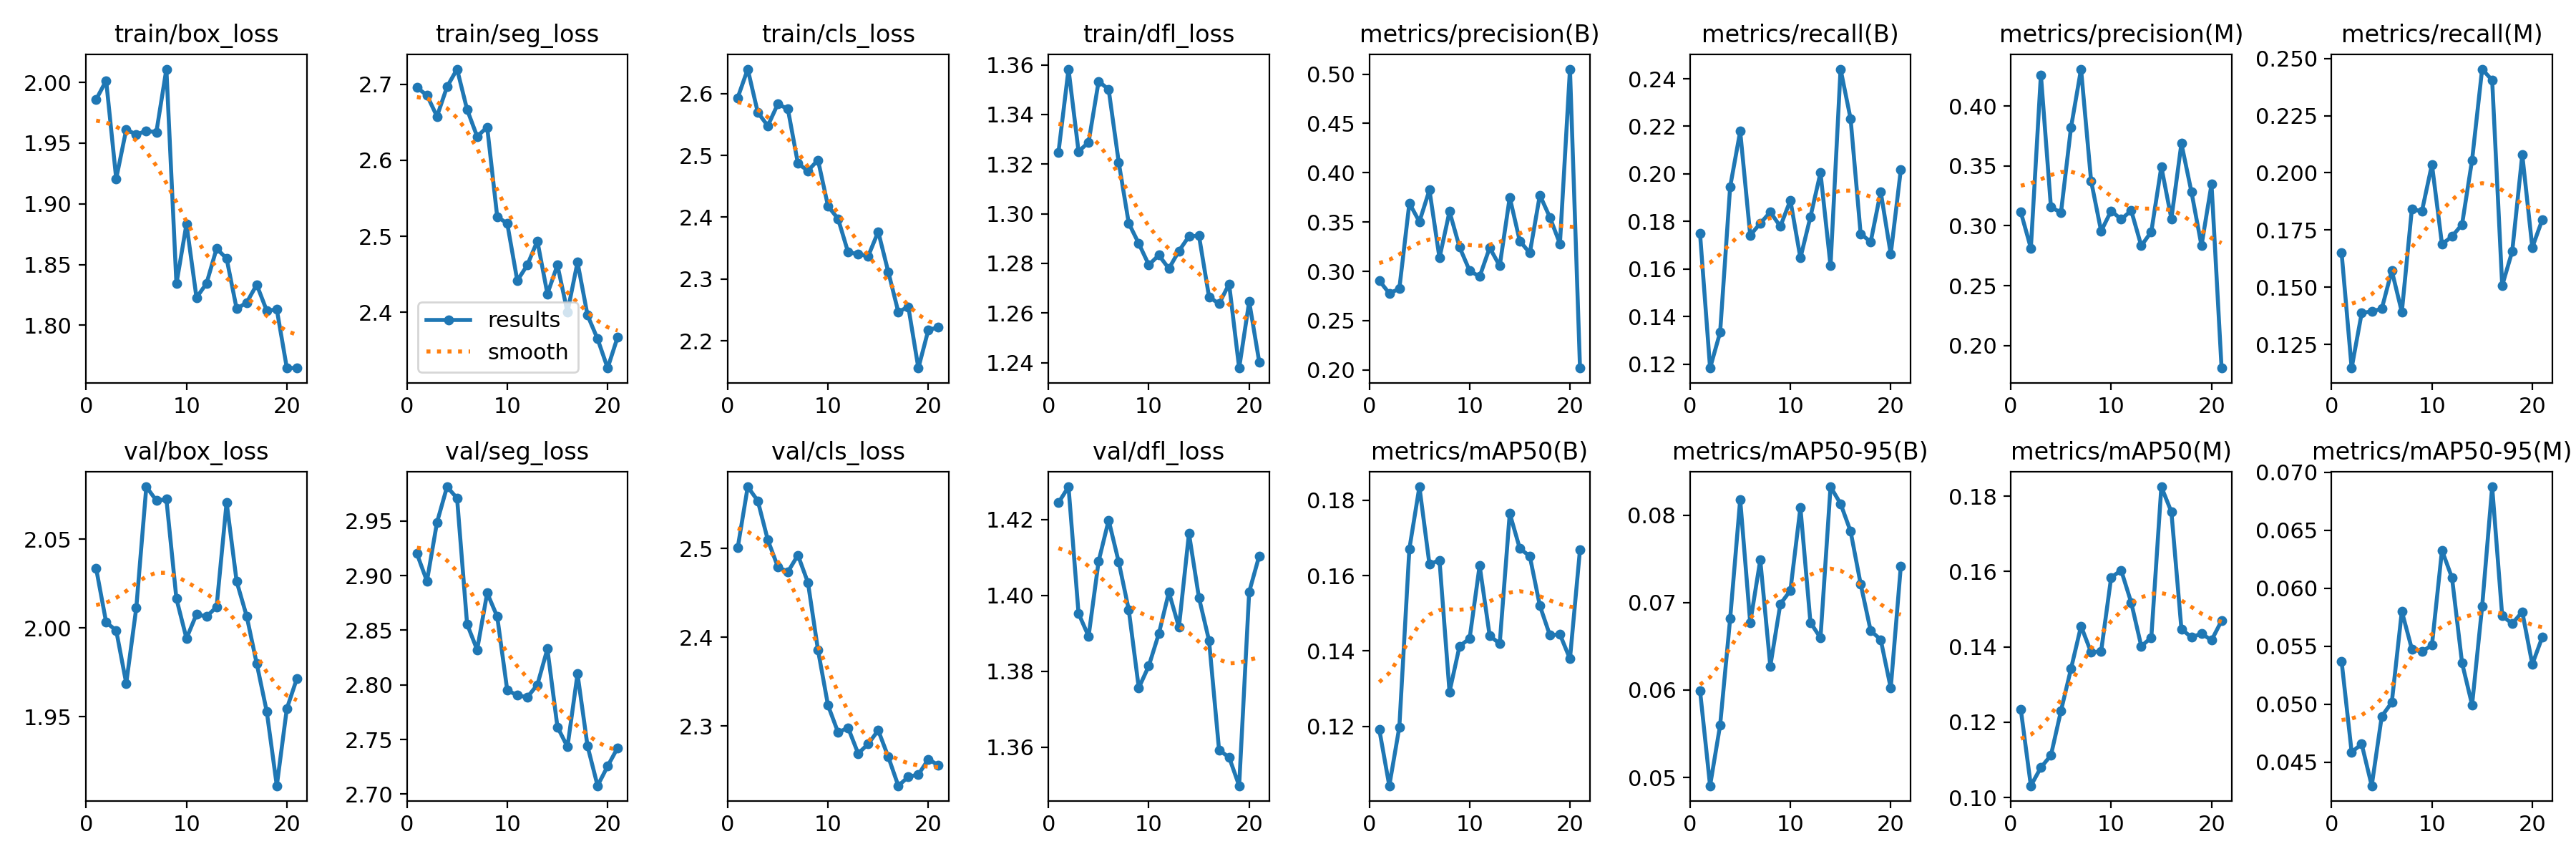

In [ ]:
Image("/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/results.png")

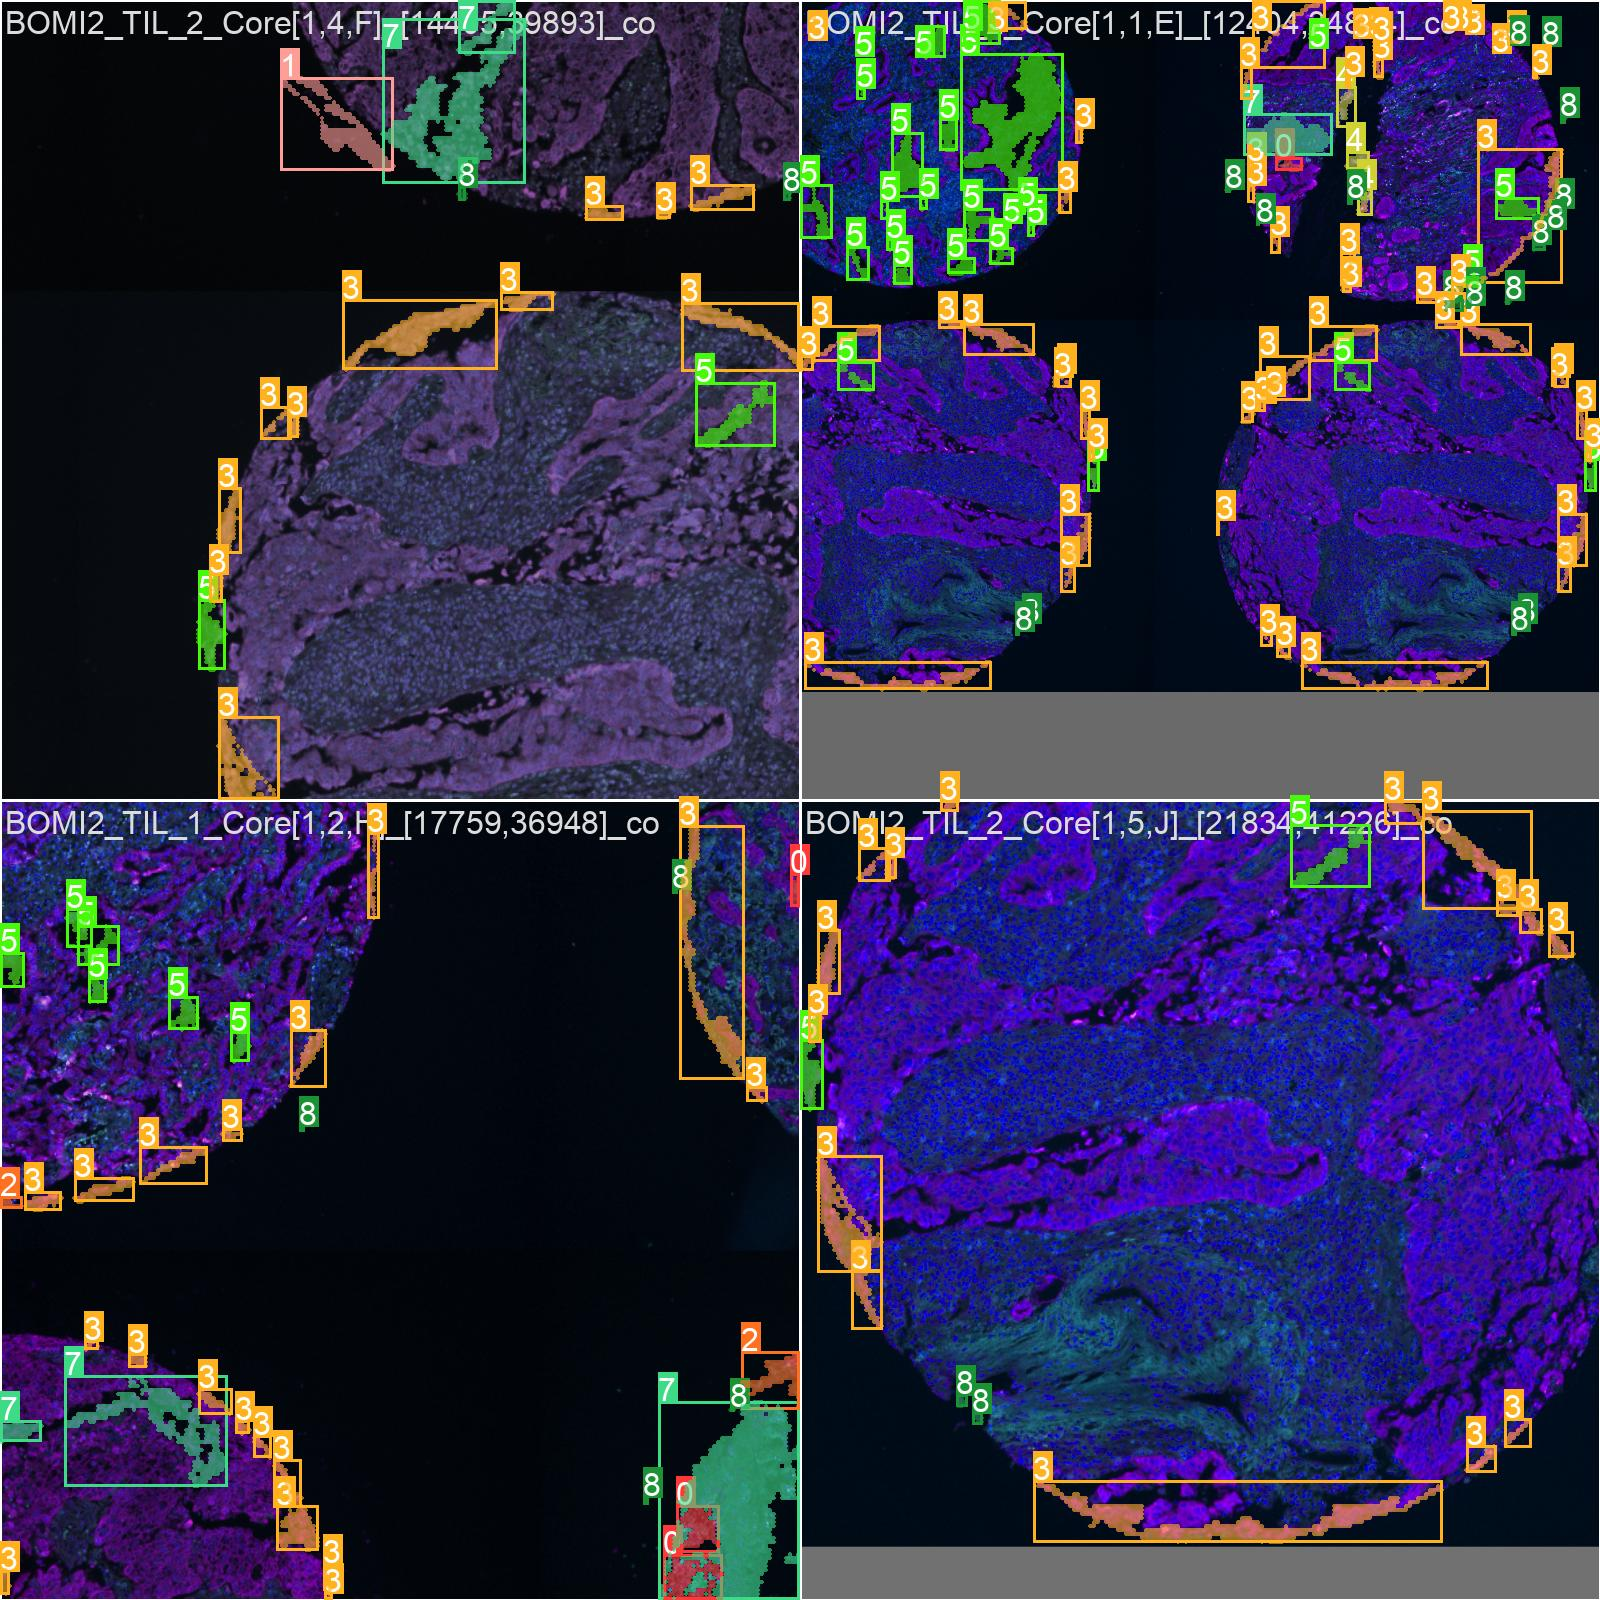

In [ ]:
Image("/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/train_batch2.jpg")

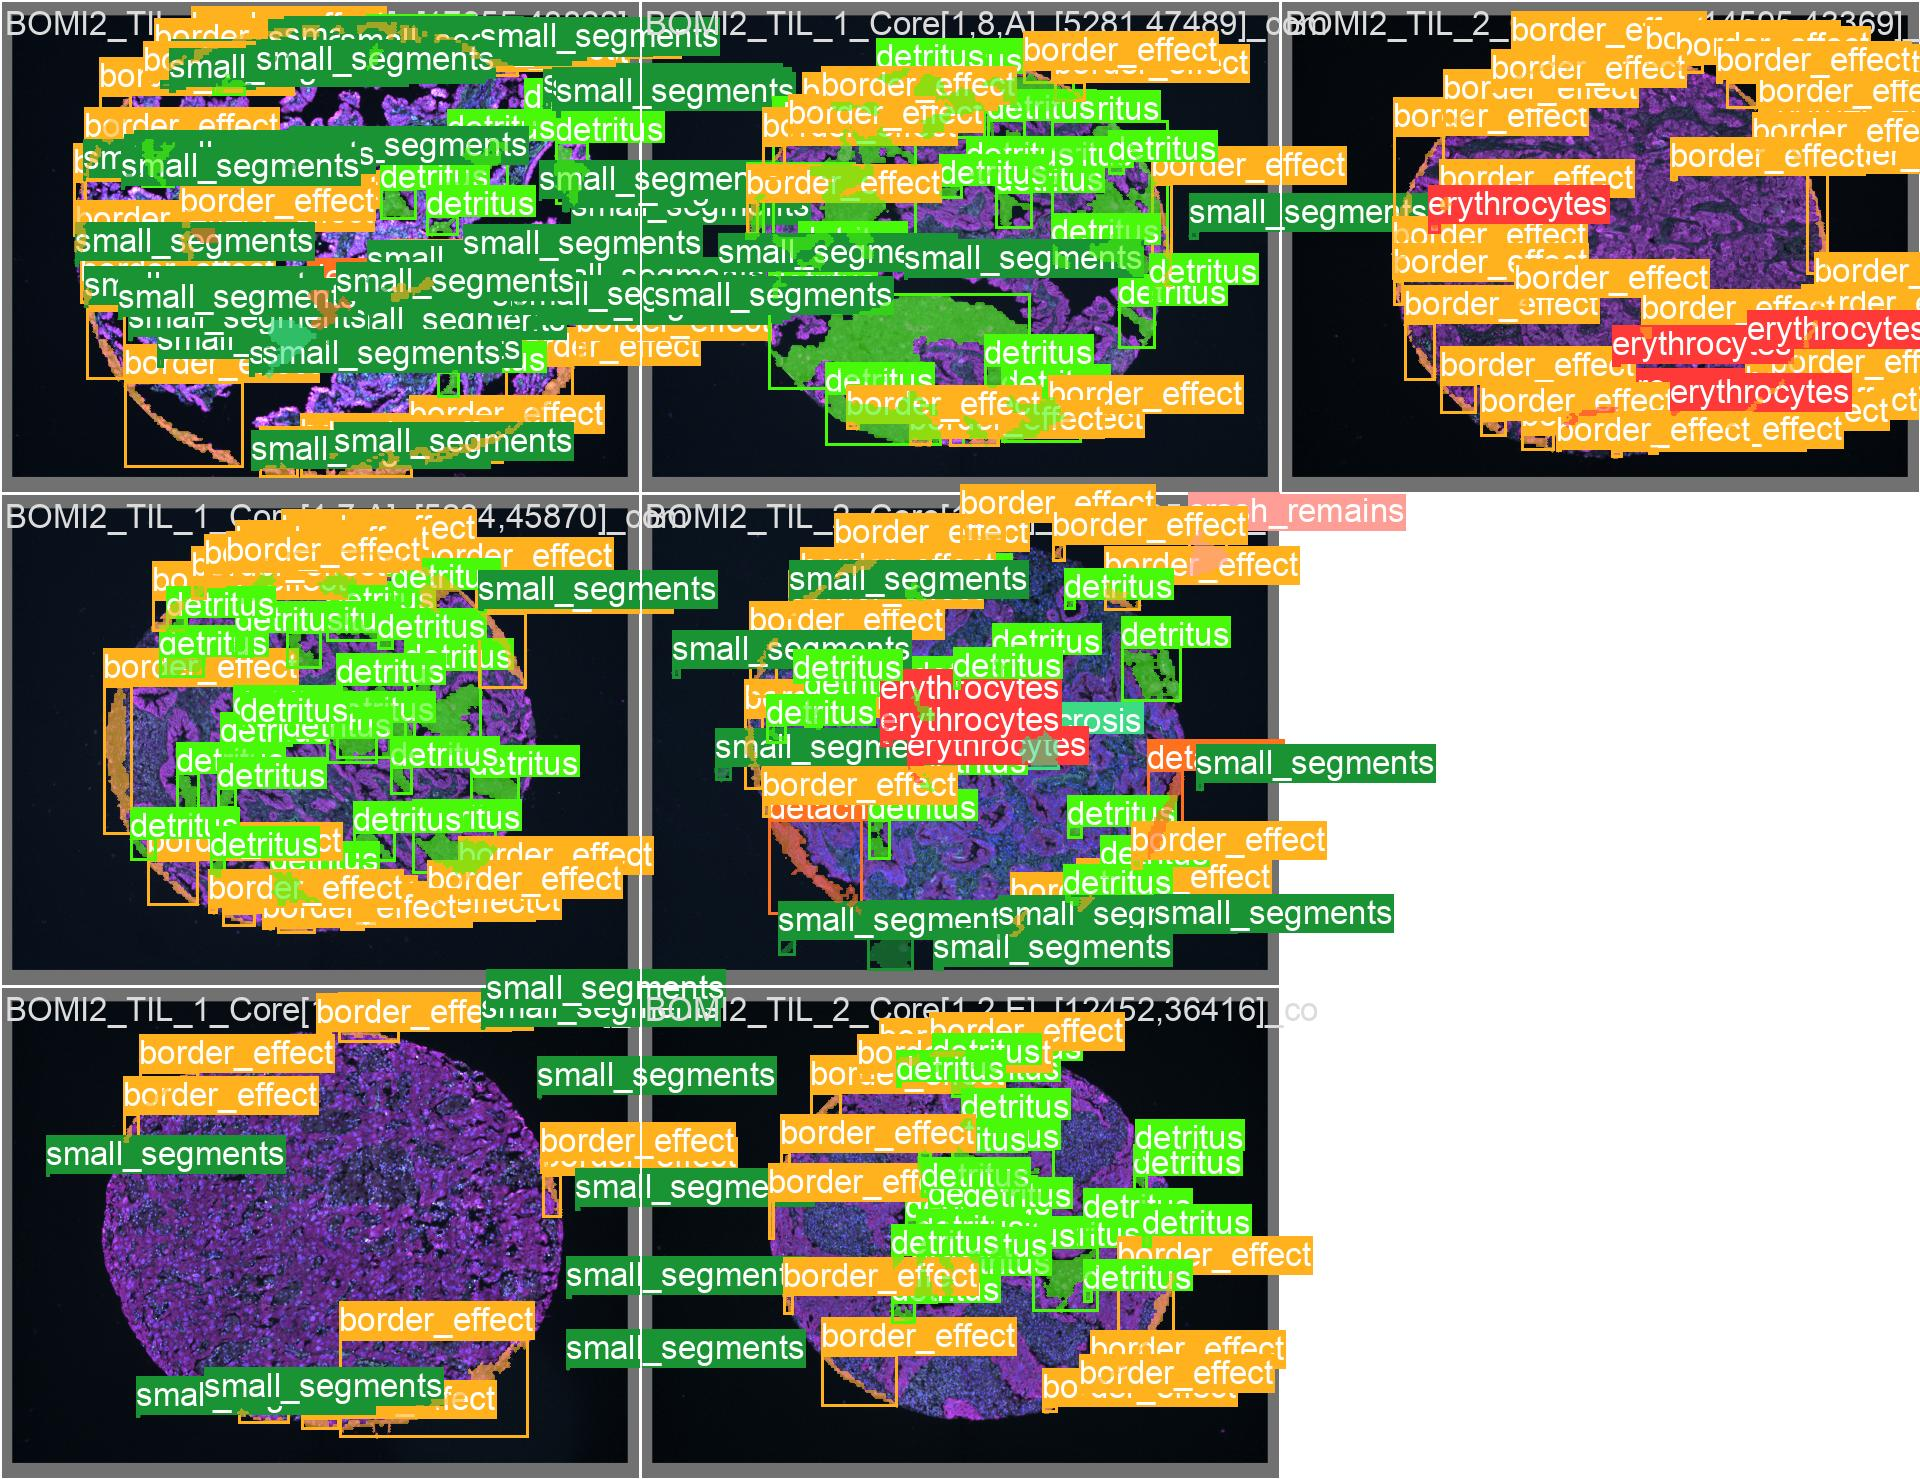

In [ ]:
Image("/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/val_batch1_labels.jpg")

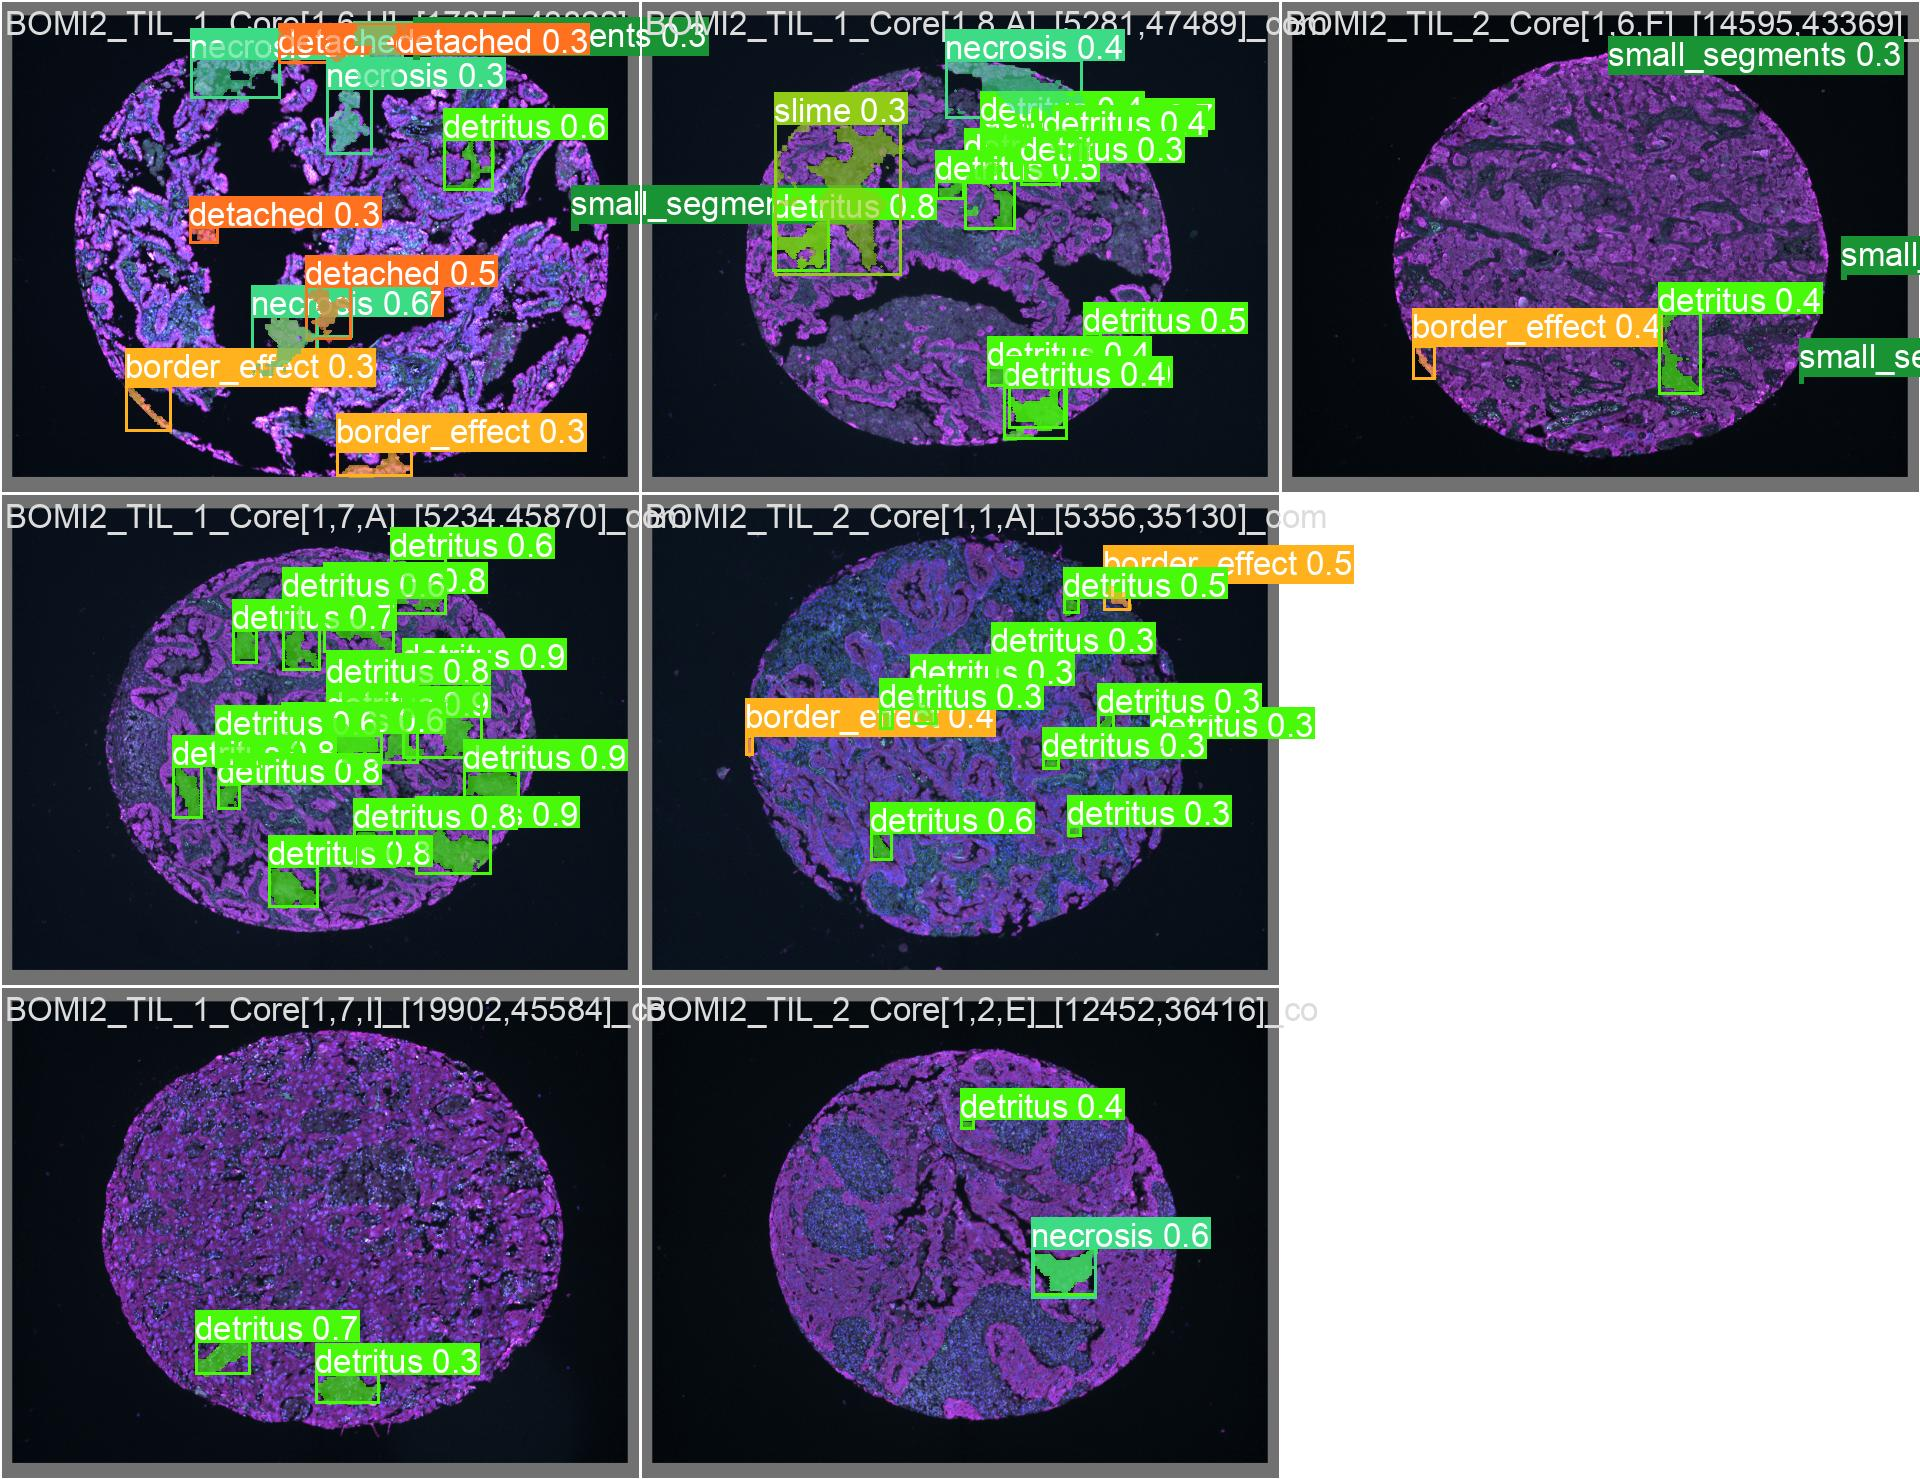

In [ ]:
Image("/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/imgsz-800/val_batch1_pred.jpg")


In [ ]:
results3 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name='patience-40',
                      imgsz=572,
                      batch = 8,
                      patience=40)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=40, batch=4, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=patience-40, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/patience-40/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/patience-40
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.15G      1.873      2.602      2.302      1.229        148        576: 100%|██████████| 23/23 [00:48<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         15        488      0.294      0.194       0.17     0.0874      0.278       0.19       0.17     0.0456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.04G      1.931      2.598      2.282      1.252        240        576: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         15        488      0.356      0.172      0.144     0.0621      0.353      0.159      0.113     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.03G      1.876      2.562      2.186      1.203        168        576: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         15        488       0.36      0.177      0.133       0.06      0.364       0.16      0.122     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.06G      2.016      2.682      2.236      1.253        137        576: 100%|██████████| 23/23 [00:41<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         15        488      0.439       0.15      0.149     0.0684      0.437       0.14      0.138     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.01G      1.919      2.648      2.215      1.238         98        576: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         15        488      0.476      0.148      0.154     0.0763      0.495      0.165      0.159     0.0575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.923G      1.932      2.556      2.216      1.225        218        576: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         15        488      0.469      0.165      0.176     0.0796      0.431      0.161      0.164     0.0511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.03G      1.963      2.629      2.192      1.226         88        576: 100%|██████████| 23/23 [00:39<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         15        488      0.514      0.185      0.192     0.0991      0.475      0.159      0.172     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         1G      2.044      2.637      2.222      1.232        121        576: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         15        488      0.454       0.17       0.15     0.0679      0.487      0.183      0.137     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.09G       1.88      2.555      2.198      1.224        149        576: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         15        488       0.39      0.207      0.156      0.066      0.355      0.182      0.144     0.0512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.979G      1.896      2.512      2.148      1.198         88        576: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         15        488       0.41      0.192      0.164     0.0632      0.319      0.173      0.134     0.0437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.04G       1.85      2.464      2.137      1.212        207        576: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         15        488      0.368      0.235      0.176     0.0724      0.391      0.174      0.144     0.0448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.02G      1.869       2.48      2.113      1.202        110        576: 100%|██████████| 23/23 [00:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         15        488      0.387      0.234      0.169     0.0669      0.382      0.185      0.144     0.0465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.05G      1.906      2.481       2.09      1.206        128        576: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         15        488      0.295      0.221      0.165     0.0693      0.219      0.155      0.126      0.044



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.04G      1.924      2.427      2.086      1.215         88        576: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         15        488      0.449      0.218      0.204      0.079      0.383      0.171      0.149     0.0485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.973G      1.838      2.443      2.082      1.211        143        576: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         15        488      0.404      0.164      0.138     0.0537      0.346       0.15      0.115     0.0395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.12G      1.871      2.415      2.044      1.193        310        576: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         15        488       0.32      0.163      0.126     0.0494      0.286      0.151      0.111     0.0388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.06G      1.905      2.525      2.066      1.191        141        576: 100%|██████████| 23/23 [00:49<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         15        488      0.274      0.172       0.12      0.049      0.267      0.156       0.11     0.0396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.992G       1.86      2.424      2.053      1.198         72        576: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         15        488       0.27      0.202      0.116     0.0501      0.304      0.133      0.109     0.0388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.09G      1.884      2.429      1.988      1.173         90        576: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         15        488      0.272      0.188      0.119      0.055      0.253       0.15     0.0992      0.035



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.967G      1.825      2.397      2.014      1.196         90        576: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         15        488      0.385      0.171      0.143      0.075      0.278      0.157      0.104     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.05G      1.841      2.434      2.041      1.188        186        576: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         15        488      0.314      0.184      0.132     0.0682      0.258       0.15     0.0936     0.0316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.967G      1.862      2.456      1.982      1.191        296        576: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         15        488       0.35      0.184      0.125     0.0605      0.287      0.181      0.106     0.0371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.956G      1.841      2.402      1.986       1.18         96        576: 100%|██████████| 23/23 [00:43<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         15        488      0.326      0.205      0.132     0.0667      0.298      0.196      0.107      0.037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.965G      1.808      2.447      2.001      1.191         82        576: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         15        488      0.327      0.212      0.163     0.0878       0.34      0.173      0.117     0.0411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.994G       1.83      2.381      1.952      1.188         73        576: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         15        488       0.33      0.244      0.159     0.0872      0.332      0.197      0.154     0.0472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.06G      1.821      2.434      1.973      1.173         66        576: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         15        488      0.336      0.173      0.156     0.0863      0.345      0.177      0.154     0.0462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.937G      1.834      2.425      1.961      1.185        237        576: 100%|██████████| 23/23 [00:45<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         15        488       0.32      0.179      0.146     0.0797      0.328       0.19      0.156      0.045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.08G      1.794      2.382      1.913      1.159        157        576: 100%|██████████| 23/23 [00:35<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         15        488      0.305      0.205      0.156     0.0813      0.288      0.199      0.126     0.0403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.975G      1.757      2.323      1.947      1.168        146        576: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         15        488      0.367      0.199      0.172     0.0875      0.325       0.19      0.129     0.0428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.95G      1.771      2.317      1.939      1.175        209        576: 100%|██████████| 23/23 [00:35<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         15        488      0.537      0.191      0.167     0.0874      0.343      0.172      0.128     0.0388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.02G      1.776      2.396      1.945      1.163        103        576: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         15        488      0.398      0.175      0.163     0.0854      0.307      0.169      0.113     0.0389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.963G      1.757      2.363      1.899      1.162        189        576: 100%|██████████| 23/23 [00:43<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         15        488      0.317      0.237      0.143     0.0711      0.276      0.206      0.113     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.07G       1.79      2.366      1.885       1.15        116        576: 100%|██████████| 23/23 [00:48<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         15        488      0.326      0.232      0.123     0.0595      0.304      0.225       0.12     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.03G      1.741      2.346       1.85      1.133        108        576: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         15        488      0.316      0.196      0.117     0.0537       0.28      0.176      0.115     0.0409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.13G      1.843      2.401      1.896      1.149        208        576: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         15        488      0.319      0.196      0.114     0.0534       0.15      0.188      0.118     0.0411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.04G       1.74      2.379       1.76      1.125         94        576: 100%|██████████| 23/23 [00:43<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         15        488      0.366      0.178      0.136     0.0636      0.213      0.177      0.131     0.0476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.01G       1.73      2.242      1.809      1.121        138        576: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         15        488      0.344      0.224      0.147     0.0721      0.167      0.196      0.132       0.05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.12G      1.724       2.29      1.846      1.121        103        576: 100%|██████████| 23/23 [00:49<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         15        488      0.238      0.213      0.146     0.0751      0.236       0.23      0.144      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.981G      1.687      2.263      1.767      1.119         86        576: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         15        488      0.198        0.2      0.135     0.0665      0.214      0.217      0.131      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.935G       1.71      2.206      1.862       1.13         58        576: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         15        488      0.223      0.183       0.14     0.0662       0.37      0.166      0.135     0.0425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.04G      1.718      2.343      1.794      1.124         84        576: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         15        488      0.412      0.142      0.133     0.0593      0.381      0.148      0.131     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.05G      1.708       2.21      1.765      1.121        102        576: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         15        488      0.203      0.168      0.129     0.0629      0.201      0.179      0.123     0.0431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.03G      1.706      2.265      1.758      1.116        156        576: 100%|██████████| 23/23 [00:50<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         15        488      0.367      0.144      0.138     0.0764      0.177      0.172       0.11     0.0434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.06G      1.677       2.22       1.71      1.125        127        576: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         15        488      0.413      0.151      0.131     0.0684      0.384       0.13      0.113     0.0436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.984G      1.694      2.202      1.707      1.112         87        576: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         15        488       0.26      0.169       0.13     0.0616      0.376      0.142      0.116     0.0411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.05G      1.735       2.31       1.83      1.124         86        576: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         15        488      0.246      0.195      0.137     0.0641      0.219      0.186      0.122     0.0439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.05G      1.634       2.18      1.652        1.1        127        576: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         15        488      0.201      0.213       0.16     0.0914      0.247      0.193      0.157     0.0525
EarlyStopping: Training stopped early as no improvement observed in last 40 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=40) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.622 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/patience-40/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/patience-40/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/patience-40/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         15        488      0.516      0.185      0.193     0.0986      0.476      0.159      0.172     0.0657
          erythrocytes          2          8      0.403      0.125      0.166      0.071      0.392      0.125      0.145      0.108
         crash_remains          6         16      0.208     0.0625     0.0566     0.0352      0.207     0.0625     0.0486     0.0313
              detached          6         15      0.463      0.267      0.256      0.111      0.459      0.267      0.258     0.0868
         border_effect         14        192      0.229     0.0885      0.087     0.0333      0.249      0.099      0.109     0.0337
     scanning_artefact          1          5          1          0          0          0          1          0          0          0
              detritus          8        119      0.586      0.269      0.301      0.127      0.581      0.268      0.282      0.111
              necrosis          4          5      0.339        0.6   

In [ ]:
results4 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name='optim-SGD',
                      optimizer="SGD",
                      momentum=0.9,
                      imgsz=572,
                      batch = 8,
                      patience=10)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=optim-SGD, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/100      1.76G      1.879      2.511      2.135      1.198        107        576: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered in

                   all         15        488      0.446      0.194       0.17     0.0832      0.453      0.186      0.159     0.0583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.67G      1.915      2.554      2.113      1.223        126        576: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         15        488       0.45      0.209      0.169     0.0771      0.526      0.156      0.153     0.0533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.67G      1.931      2.451      2.112      1.218        186        576: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        488      0.422      0.222      0.175     0.0727      0.397      0.171      0.151      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.66G      1.971      2.606       2.16      1.226        148        576: 100%|██████████| 12/12 [00:25<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         15        488      0.361      0.204      0.135     0.0564      0.381      0.204      0.147     0.0516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.63G      1.884      2.536       2.11       1.21        140        576: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         15        488      0.241      0.172      0.131     0.0561      0.394      0.148      0.132     0.0392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.79G      1.957       2.61      2.159      1.234        146        576: 100%|██████████| 12/12 [00:30<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15        488      0.221      0.178      0.126     0.0571      0.208      0.177       0.13     0.0407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.69G       2.02      2.598      2.145      1.244         89        576: 100%|██████████| 12/12 [00:19<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         15        488      0.372       0.15       0.15     0.0661      0.354      0.141      0.148     0.0519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.72G      2.005      2.595      2.144      1.247        137        576: 100%|██████████| 12/12 [00:26<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         15        488      0.336      0.175      0.132     0.0568      0.329      0.167      0.132     0.0476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.77G      1.922      2.699      2.066      1.203        182        576: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         15        488      0.341      0.187      0.151     0.0659      0.312      0.147      0.137     0.0439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.62G      1.877      2.674      2.111      1.209         94        576: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         15        488       0.36      0.156      0.141     0.0598      0.301      0.149      0.118     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.72G      1.972      2.625      2.087      1.225        150        576: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15        488      0.363      0.164      0.132     0.0565      0.354      0.122        0.1     0.0355
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.106 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


                   all         15        488      0.443      0.195       0.17     0.0833      0.447      0.184      0.159     0.0582
          erythrocytes          2          8      0.334      0.125      0.103       0.04       0.34      0.125     0.0803     0.0562
         crash_remains          6         16      0.171     0.0625     0.0631     0.0453      0.343      0.125     0.0991     0.0434
              detached          6         15      0.377      0.267      0.267      0.116      0.473      0.333       0.28     0.0893
         border_effect         14        192      0.193      0.099     0.0928     0.0345      0.221      0.109      0.113     0.0329
     scanning_artefact          1          5          1          0          0          0          1          0          0          0
              detritus          8        119       0.52      0.319      0.309      0.129       0.53      0.319      0.302      0.118
              necrosis          4          5      0.323        0.6   

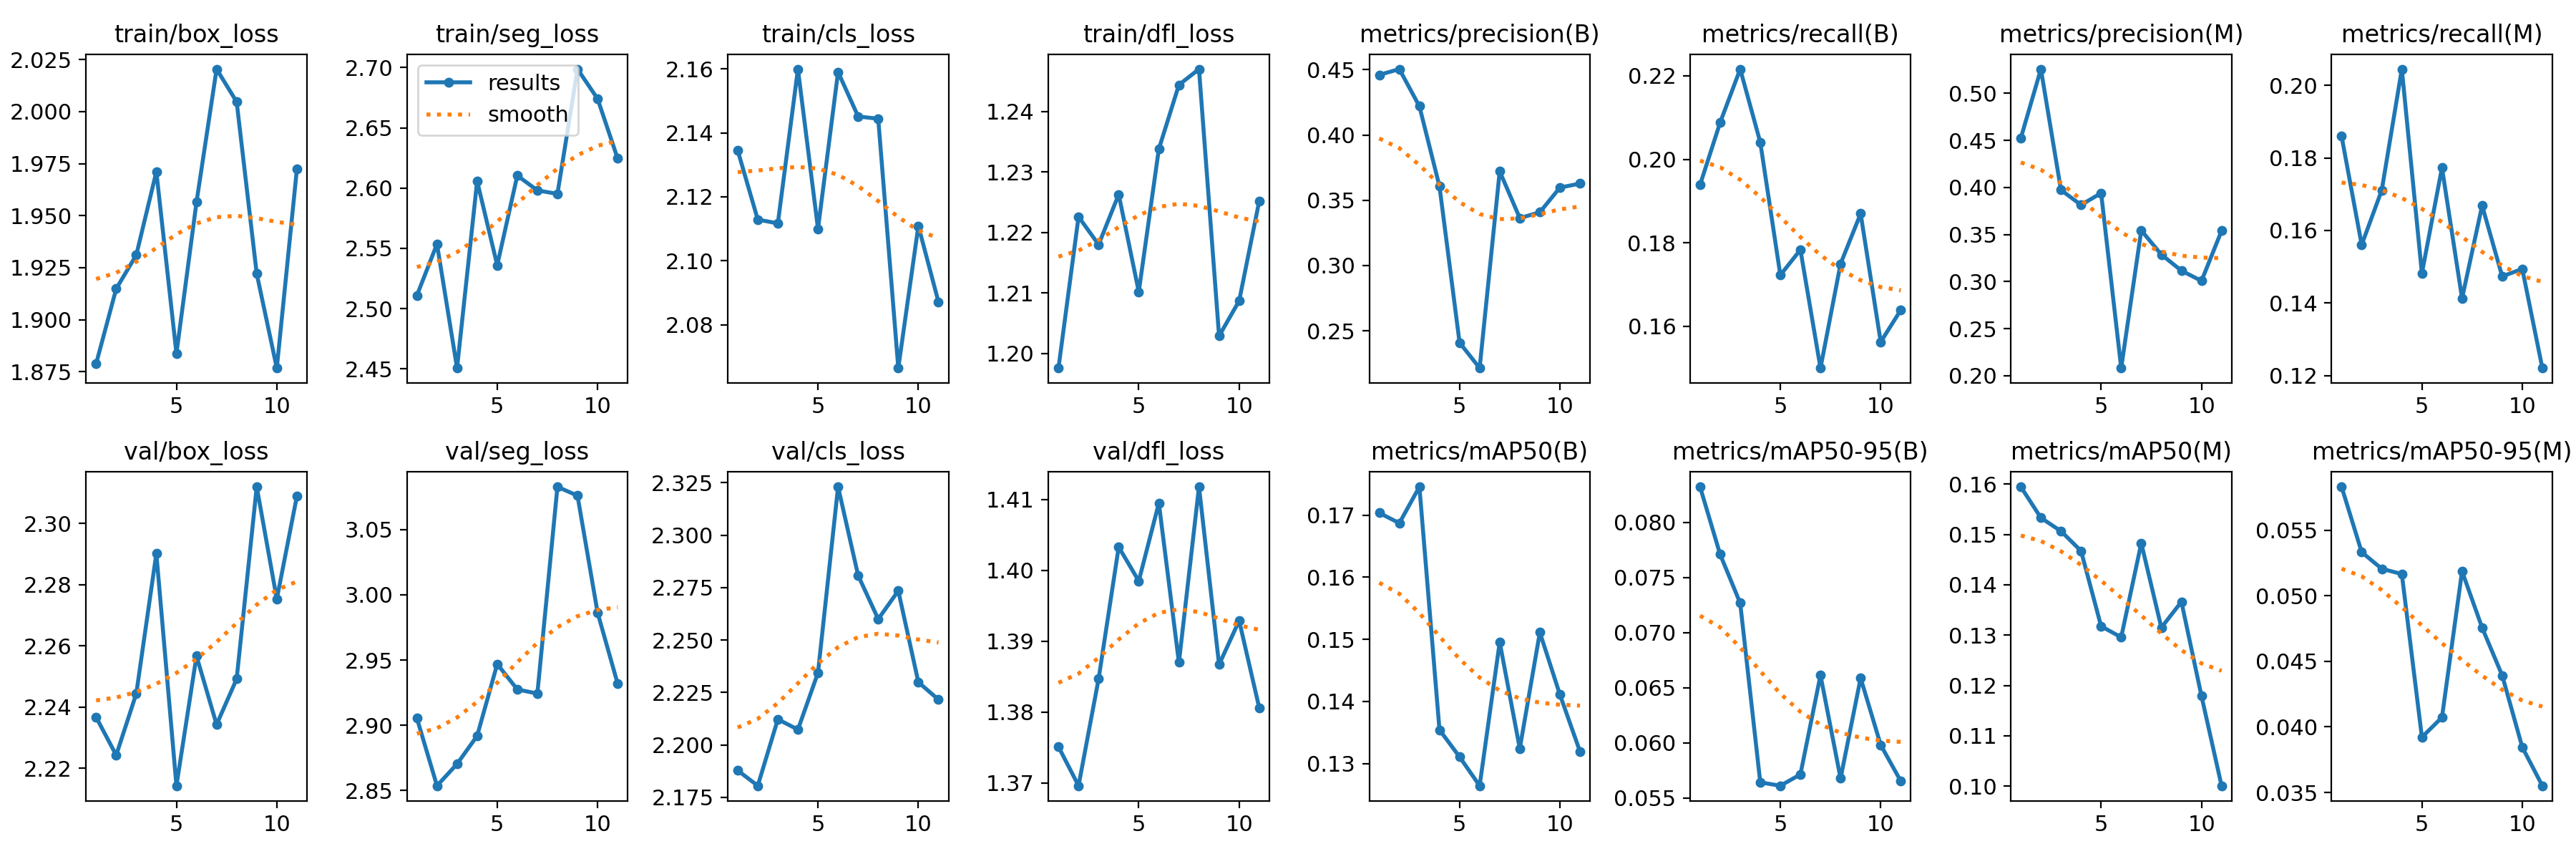

In [ ]:
Image("/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/optim-SGD/results.png")

In [ ]:
results5 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name='loss_weights',
                      optimizer="SGD",
                      momentum=0.95,
                      box=0.25,
                      cls=0.65,
                      imgsz=572,
                      batch = 8,
                      patience=10)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=loss_weights, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/loss_weights/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.95) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/loss_weights
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.7G    0.06012    0.08127      2.687      1.174        107        576: 100%|██████████| 12/12 [00:46<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         15        488       0.37      0.227      0.181     0.0879      0.425      0.168      0.178     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.66G    0.06404    0.08538      2.716      1.225        126        576: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         15        488      0.368      0.211      0.162     0.0716      0.352      0.174      0.148     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.67G    0.06395    0.08267      2.706      1.217        186        576: 100%|██████████| 12/12 [00:29<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         15        488      0.369      0.196      0.142      0.061      0.367      0.192      0.128     0.0435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.66G    0.06469    0.08802      2.772      1.221        148        576: 100%|██████████| 12/12 [00:22<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15        488      0.376      0.164      0.141     0.0642      0.352      0.155      0.134      0.044



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.63G    0.06247    0.08565      2.695      1.209        140        576: 100%|██████████| 12/12 [00:26<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         15        488      0.196      0.199       0.15     0.0675      0.156      0.169      0.107      0.038



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.79G    0.06609    0.08887      2.842       1.24        146        576: 100%|██████████| 12/12 [00:29<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         15        488      0.225      0.171      0.161     0.0774      0.149      0.167      0.111     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.69G    0.06677    0.08828      2.807      1.251         89        576: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         15        488      0.197      0.162      0.148     0.0768      0.252       0.12      0.133     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.72G    0.06545    0.08643      2.818      1.232        137        576: 100%|██████████| 12/12 [00:25<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         15        488      0.183      0.216      0.144      0.074      0.148      0.134      0.104     0.0376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.78G    0.06415    0.08861      2.762      1.195        182        576: 100%|██████████| 12/12 [00:29<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         15        488      0.237      0.197      0.163     0.0891      0.174      0.142      0.113     0.0422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.65G    0.06141    0.08566      2.691      1.207         94        576: 100%|██████████| 12/12 [00:24<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         15        488      0.354      0.163      0.192     0.0944      0.224      0.147      0.145     0.0447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.72G    0.06651    0.08894      2.721      1.245        150        576: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         15        488      0.168      0.185      0.128      0.066      0.134      0.152      0.112     0.0379
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.112 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/loss_weights/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/loss_weights/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/loss_weights/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


                   all         15        488      0.376      0.229      0.181     0.0877      0.425      0.168      0.178     0.0657
          erythrocytes          2          8      0.215     0.0805     0.0536     0.0206          0          0     0.0536     0.0388
         crash_remains          6         16      0.105     0.0625     0.0612     0.0447      0.346      0.125     0.0962     0.0512
              detached          6         15      0.263      0.405      0.265      0.105      0.461      0.333      0.276     0.0802
         border_effect         14        192      0.202      0.203      0.116     0.0397      0.294      0.104      0.135      0.039
     scanning_artefact          1          5          1          0          0          0          1          0          0          0
              detritus          8        119      0.412      0.353      0.311      0.138       0.57      0.319      0.333      0.127
              necrosis          4          5      0.262        0.6   

In [ ]:
results6 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml',
                      epochs = 100,
                      project = project,
                      name='Optim_RMSprop',
                      optimizer="RMSProp",
                      momentum=0.95,
                      box=0.25,
                      cls=0.65,
                      imgsz=572,
                      batch = 8,
                      patience=10)

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo, name=Optim_RMSprop, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/Optim_RMSprop/labels.jpg... 
optimizer: RMSprop(lr=0.01, momentum=0.95) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/Optim_RMSprop
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.75G     0.1077     0.1851      5.528      2.104        107        576: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.71G     0.1453     0.2029      5.554      2.746        126        576: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100       1.7G     0.1447     0.1879      5.211       2.82        186        576: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.69G     0.1419     0.2047      5.336      3.009        148        576: 100%|██████████| 12/12 [00:24<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.67G     0.1404     0.2085      5.164      2.751        140        576: 100%|██████████| 12/12 [00:30<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.85G     0.1387     0.1731      4.922      2.602        146        576: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.73G     0.1421     0.1732      5.157      2.675         89        576: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.77G       0.14     0.1717      5.261       2.69        137        576: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.82G     0.1378     0.1742      5.454      2.747        182        576: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.68G     0.1366     0.1908      4.969      2.736         94        576: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.78G     0.1394     0.1901      4.945      2.693        150        576: 100%|██████████| 12/12 [00:29<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         15        488          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.61G     0.1366     0.1845      4.909      2.806        166        576: 100%|██████████| 12/12 [00:36<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         15        488      0.254      0.025    0.00156   0.000311      0.251   0.000651    0.00016    1.6e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.86G     0.1371     0.1827      4.894      2.747        201        576: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         15        488      0.254      0.025    0.00156   0.000311      0.251   0.000651    0.00016    1.6e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.97G     0.1352     0.1762      4.894      2.668        106        576: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         15        488      0.251   0.000651   4.82e-05   4.82e-06      0.251     0.0013    5.9e-05   7.89e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       1.8G     0.1364     0.1815      4.864      2.718         80        576: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         15        488   0.000903    0.00326    0.00048   0.000104          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.91G     0.1329     0.1748      4.781      2.653        124        576: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         15        488    0.00214    0.00391   0.000711   0.000127          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.71G     0.1315     0.1753      4.631       2.56        146        576: 100%|██████████| 12/12 [00:24<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.67G     0.1299     0.1842      4.676      2.615        102        576: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.84G     0.1299     0.1945      4.717      2.759        104        576: 100%|██████████| 12/12 [00:29<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.87G     0.1324     0.1808      4.881      2.732        171        576: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.91G     0.1313     0.1787      4.764      2.547        122        576: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.75G      0.132     0.1777      4.627      2.513        169        576: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         15        488      0.252    0.00586   0.000637   0.000205      0.252     0.0026   0.000315   7.11e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.66G     0.1307     0.1745      4.737      2.519         61        576: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         15        488    0.00298     0.0682    0.00187   0.000503   0.000846    0.00326   0.000472   7.31e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       1.7G     0.1293     0.1726      4.774      2.526        153        576: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         15        488      0.125       0.05   0.000148   7.09e-05      0.125      0.025   6.16e-05   6.16e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.76G     0.1286     0.1742      4.687      2.534        111        576: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         15        488    0.00501     0.0927     0.0368    0.00423   0.000788     0.0276   0.000491   0.000105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.61G     0.1254     0.1735       4.55      2.483        159        576: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         15        488    0.00168     0.0451    0.00192   0.000439   0.000492    0.00964    0.00117   0.000137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.57G      0.125     0.1737      4.555      2.504        112        576: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15        488    0.00173     0.0345     0.0011   0.000283          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.66G     0.1266     0.1725      4.608      2.503        147        576: 100%|██████████| 12/12 [00:30<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         15        488   0.000738     0.0163   0.000412   0.000123          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.66G     0.1248        nan      4.556      2.446        142        576: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         15        488   0.000388     0.0585    0.00049   0.000194          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.84G     0.1255        nan      4.589      2.456        130        576: 100%|██████████| 12/12 [00:35<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         15        488   0.000256     0.0507   0.000448   0.000137          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.61G     0.1282        nan      4.605       2.49        116        576: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         15        488    0.00242     0.0714    0.00191   0.000605          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.83G     0.1284        nan      4.506      2.495         87        576: 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         15        488    0.00256     0.0748    0.00198   0.000609          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.69G     0.1283        nan      4.555      2.487         95        576: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15        488   0.000497     0.0563   0.000715   0.000299          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.93G     0.1269        nan      4.536      2.549        126        576: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         15        488   0.000534     0.0563    0.00116   0.000362          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.75G     0.1275        nan      4.572       2.56        133        576: 100%|██████████| 12/12 [00:36<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         15        488    0.00145     0.0339    0.00147   0.000317          0          0          0          0


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 25, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

35 epochs completed in 0.346 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/Optim_RMSprop/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/Optim_RMSprop/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo/Optim_RMSprop/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


                   all         15        488    0.00477     0.0908     0.0191    0.00478   0.000854     0.0276     0.0126    0.00131
          erythrocytes          2          8          0          0          0          0          0          0          0          0
         crash_remains          6         16   0.000813      0.125   0.000538   0.000125          0          0          0          0
              detached          6         15     0.0161      0.133     0.0295    0.00442          0          0          0          0
         border_effect         14        192     0.0196     0.0677     0.0107    0.00233    0.00603     0.0208    0.00332   0.000728
     scanning_artefact          1          5          0          0          0          0          0          0          0          0
              detritus          8        119          0          0          0          0          0          0          0          0
              necrosis          4          5     0.0016        0.4   

### Experiments with 7 classes

In [ ]:
project_2 = "/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class"
name_2 = "base"

results7 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset2.yaml',
                      epochs = 100,
                      project = project_2,
                      name=name_2,
                      optimizer="RMSProp",
                      momentum=0.95,
                      box=0.25,
                      cls=0.65,
                      imgsz=572,
                      batch = 8,
                      patience=10)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset2.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class, name=base2, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train... 91 images, 2 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:02<00:00, 38.16it/s]

train: New cache created: /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 36.25it/s]

val: New cache created: /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache
Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base2/labels.jpg... 


optimizer: RMSprop(lr=0.01, momentum=0.95) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      0.127      2.101      6.724      3.299         65        576: 100%|██████████| 12/12 [01:16<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.69s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.1357     0.7381      5.929      3.166         33        576: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.80s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.1346     0.2233      5.775      3.046         77        576: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.1366     0.1854      5.686      2.939         22        576: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.34s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.1383     0.1805      5.701      2.902         81        576: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.63s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.1334       0.18      5.587      2.743         50        576: 100%|██████████| 12/12 [01:11<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.27s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.1357     0.1812      5.461      2.712         60        576: 100%|██████████| 12/12 [01:03<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.11s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.1369     0.1837      5.462      2.714        103        576: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.17s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.1364     0.1813      5.475      2.646        107        576: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.57s/it]

                   all         15        296          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.1409     0.1831      5.748      2.801         40        576: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

                   all         15        296   0.000102     0.0012   5.25e-05   5.25e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.1373     0.1852      5.598      2.768         61        576: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]

                   all         15        296   0.000102     0.0012   5.25e-05   5.25e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.1338     0.1849      5.429      2.694         89        576: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.61s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.1336     0.1842      5.394        2.7         62        576: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.99s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.1357     0.1797      5.568      2.631         43        576: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.75s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.1354     0.1786       5.58      2.663         47        576: 100%|██████████| 12/12 [01:13<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.39s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.1362     0.1819      5.449      2.671         58        576: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.1351     0.1791      5.457      2.676         62        576: 100%|██████████| 12/12 [00:52<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.1356     0.1793      5.522      2.702         56        576: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.70s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      0.136     0.1796      5.308      2.642         44        576: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.79s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.1371     0.1777      5.304      2.612         49        576: 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.72s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      0.138       0.18      5.304       2.64         78        576: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.53s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.1395      0.178      5.324      2.627        152        576: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.1351     0.1779      5.191      2.658         91        576: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      0.135     0.1769       5.22      2.712         88        576: 100%|██████████| 12/12 [00:48<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.1348     0.1775       5.27      2.656        133        576: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.1336     0.1771      5.179      2.607         71        576: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.1337      0.176      5.266      2.663         59        576: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.1343     0.1788      5.396       2.59         62        576: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.10s/it]

                   all         15        296   6.85e-05     0.0012    3.5e-05      7e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.1305     0.1772      5.211      2.603         67        576: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]

                   all         15        296      0.429     0.0571    0.00134   0.000474          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      0.133     0.1778      5.277      2.599         32        576: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.27s/it]

                   all         15        296    0.00043     0.0571   0.000533   0.000244          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.1337     0.1775      5.259       2.58         71        576: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]

                   all         15        296    0.00043     0.0571   0.000533   0.000244          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.1305     0.1753      5.074      2.596         58        576: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]

                   all         15        296    0.00043     0.0571   0.000533   0.000244          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.1319     0.1754      5.086      2.642         40        576: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

                   all         15        296       0.29    0.00893   0.000428   6.23e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.1341     0.1757      5.119      2.629         76        576: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]

                   all         15        296      0.572    0.00893   0.000115   2.88e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.1297     0.1742      5.194      2.588         96        576: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.54s/it]

                   all         15        296      0.286    0.00893   3.85e-05   3.85e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.1293     0.1746      5.284      2.611         42        576: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

                   all         15        296      0.432    0.00893   0.000413   4.13e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.1311     0.1746      5.172      2.577        134        576: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.39s/it]

                   all         15        296      0.432    0.00893   0.000413   4.13e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G       0.13     0.1743      5.215      2.555         47        576: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.47s/it]

                   all         15        296      0.432    0.00893   0.000413   4.13e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.1343     0.1754      5.102      2.557         79        576: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.43s/it]

                   all         15        296      0.478    0.00893    0.00575   0.000575          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.1342     0.1754      5.391      2.553         28        576: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.39s/it]

                   all         15        296      0.329    0.00893    0.00521   0.000521          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.1311     0.1742      5.236      2.615         57        576: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]

                   all         15        296      0.329    0.00893    0.00521   0.000521          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.1314     0.1776      5.064      2.485         78        576: 100%|██████████| 12/12 [00:52<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]

                   all         15        296      0.329    0.00893    0.00521   0.000521          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.1295     0.1745      5.098      2.505         58        576: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.04s/it]

                   all         15        296      0.329    0.00893    0.00521   0.000521          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.1339     0.1775      5.143      2.555        106        576: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.17s/it]

                   all         15        296      0.329    0.00893    0.00521   0.000521          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.1282     0.1755      5.022      2.528        100        576: 100%|██████████| 12/12 [00:51<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]

                   all         15        296    0.00138     0.0577   0.000931    0.00019   0.000444    0.00952   0.000342   3.42e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.1333     0.1751      5.013      2.532         33        576: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]

                   all         15        296   0.000751      0.047    0.00137   0.000395          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.1334     0.1763      5.051      2.476         67        576: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]

                   all         15        296    0.00112     0.0435    0.00188   0.000488    0.00037     0.0119   0.000199   1.99e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.1291      0.175      4.968      2.481         62        576: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]

                   all         15        296   0.000767     0.0423   0.000997   0.000166   0.000191     0.0107   0.000118   1.88e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.1316     0.1782      5.116      2.433         37        576: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.36s/it]

                   all         15        296    0.00076     0.0661    0.00548   0.000555          0          0          0          0
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



49 epochs completed in 0.886 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base2/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base2/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base2/weights/best.pt...
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3259429 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]


                   all         15        296      0.429     0.0179   0.000128    2.1e-05   4.14e-05    0.00893   2.54e-05   5.08e-06
          erythrocytes          2          8          1          0          0          0          0          0          0          0
         crash_remains          6         16    0.00312      0.125   0.000895   0.000147    0.00029     0.0625   0.000178   3.56e-05
              detached          6         15          0          0          0          0          0          0          0          0
     scanning_artefact          1          5          0          0          0          0          0          0          0          0
              detritus          8        119          1          0          0          0          0          0          0          0
              necrosis          4          5          1          0          0          0          0          0          0          0
        small_segments         13        128          0          0   

In [ ]:
results8 = model.train(data='/content/drive/MyDrive/pathdata/wsi_dataset/dataset2.yaml',
                      epochs = 100,
                      project = project_2,
                      name="base3_momentum=0.99",
                      momentum=0.99,
                      imgsz=572,
                      batch = 8,
                      patience=10)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/pathdata/wsi_dataset/dataset2.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=572, save=True, save_period=-1, cache=False, device=None, workers=0, project=/content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class, name=base3_momentum=0.99, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/train... 101 images, 2 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:03<00:00, 31.59it/s]


train: New cache created: /content/drive/MyDrive/pathdata/wsi_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/pathdata/wsi_dataset/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 36.95it/s]

val: New cache created: /content/drive/MyDrive/pathdata/wsi_dataset/labels/val.cache
Plotting labels to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99/labels.jpg... 


optimizer: RMSprop(lr=0.01, momentum=0.99) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 576 train, 576 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G     0.1395     0.4349      15.22        3.5        153        576: 100%|██████████| 13/13 [01:23<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]

                   all         10        204          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.1405      0.281      8.731      3.451        161        576: 100%|██████████| 13/13 [01:06<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

                   all         10        204          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.1436     0.2011      7.546      3.617        183        576: 100%|██████████| 13/13 [01:07<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]

                   all         10        204      7e-05     0.0286   5.67e-05   2.84e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.1405     0.1906      11.76      3.382        133        576: 100%|██████████| 13/13 [01:02<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]

                   all         10        204      7e-05     0.0286   5.67e-05   2.84e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.1377     0.2108      6.717      3.874         60        576: 100%|██████████| 13/13 [01:09<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.1386     0.2112      8.144      3.794        100        576: 100%|██████████| 13/13 [01:03<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.49s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.1361      0.191      7.504       3.62        123        576: 100%|██████████| 13/13 [01:10<00:00,  5.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.1414     0.1879      7.796      3.374        171        576: 100%|██████████| 13/13 [01:06<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.1418     0.1884       7.11      3.657        119        576: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.1417     0.1903      6.753      3.823        168        576: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all         10        204      0.143     0.0286     0.0013    0.00013          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      0.143     0.1809      9.265      3.607        127        576: 100%|██████████| 13/13 [01:02<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.1419     0.1823      7.769      3.734         79        576: 100%|██████████| 13/13 [01:03<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      0.143      0.181       7.14      3.524        130        576: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.1388     0.1815      7.289      3.455         94        576: 100%|██████████| 13/13 [01:05<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.1404     0.1841      15.64      3.453        122        576: 100%|██████████| 13/13 [01:11<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.1397     0.1847         16      3.625        118        576: 100%|██████████| 13/13 [01:06<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.1411     0.1861      7.782      3.864         65        576: 100%|██████████| 13/13 [01:07<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.90s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.1395     0.1765      6.864      3.562         97        576: 100%|██████████| 13/13 [00:59<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.1383     0.1779      6.764      3.505         61        576: 100%|██████████| 13/13 [01:09<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]

                   all         10        204   0.000102    0.00295   5.31e-05   1.58e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.1444     0.1781      29.17      3.527         49        576: 100%|██████████| 13/13 [00:59<00:00,  4.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]

                   all         10        204      0.143     0.0476   0.000385   0.000167          0          0          0          0
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 10, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



20 epochs completed in 0.407 hours.
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99/weights/best.pt...
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3259429 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  6.00s/it]

                   all         10        204      0.143     0.0476   0.000385   0.000167          0          0          0          0
          erythrocytes          2          8          0          0          0          0          0          0          0          0
         crash_remains          3          5          1          0          0          0          0          0          0          0
              detached          2          4          0          0          0          0          0          0          0          0
     scanning_artefact          1          5          0          0          0          0          0          0          0          0
              detritus          5         97          0          0          0          0          0          0          0          0
              necrosis          3          3    0.00401      0.333     0.0027    0.00117          0          0          0          0
        small_segments          8         82          0          0   

Speed: 0.7ms preprocess, 58.3ms inference, 0.0ms loss, 74.3ms postprocess per image
Results saved to /content/drive/MyDrive/pathdata/wsi_dataset/results/yolo_7class/base3_momentum=0.99
